# Wordle
Attempting to determine the optimal starting word for the popular online game.

https://www.nytimes.com/games/wordle/index.html

In [1]:
import pandas as pd
import numpy as np

## To Do

✓ Pull list of all accepted 5-letter words  
--- Look in wordle page source? Scrape?  
--- https://www.nytimes.com/games-assets/v2/wordle.6b88b1c8c6541b07820ab0896f6bc19be0ae34b2.js  
✓ Allow for easy input/lookup of a custom 5-letter word and score it  
✓ Track whether word is a solution or not  
✓ Track whether word has duplicate letters or not  
--- Count unique vals in row? If = 5 then dup = False  
✓ Update plot y-axis to be based on max of LETTER values (not word scores)  
☐ Pare down list to remove words with duplicate letters   
☐ Account for yellows?  
--- Base on `lxsum` col  

## Get input files and load into dataframes

Input files have been gerated via [this notebook](wordle_source_parsing.ipynb). 

In [2]:
# set filenames for solutions plus eligible plays
solutions_file = 'wordle_solutions.csv'
plays_file = 'wordle_plays.csv'

In [3]:
# load solution list
df_sol = pd.read_csv(solutions_file)
# rename the column
df_sol.columns = ['full_word']
# add a column to track whether word is a potential solution or not
df_sol['is_sol'] = True

df_sol.head()

,full_word,is_sol
0,aback,True
1,abase,True
2,abate,True
3,abbey,True
4,abbot,True


In [4]:
# load list of all possible plays
df_plays = pd.read_csv(plays_file)
# rename the column
df_plays.columns = ['full_word']
# add a column to track whether word is a potential solution or not
df_plays['is_sol'] = False

df_plays.head()

,full_word,is_sol
0,aahed,False
1,aalii,False
2,aargh,False
3,aarti,False
4,abaca,False


In [5]:
# build function to break up words into individual letters 
# this function returns the dataframe plus a list of all column names
def extract_letters(df):
    looprange = range(0,5) # we know we will only have 5 columns
    colnames_all = []
    for i in looprange:
        colname = 'l'+str(i+1)
        colnames_all.append(colname) # keep a running list of all col names so we can iterate later
        df[colname] = df['full_word'].str[i]
    return df, colnames_all

In [6]:
# break up words into individual letters 
df_sol, colnames_all = extract_letters(df_sol)

df_sol.head()

,full_word,is_sol,l1,l2,l3,l4,l5
0,aback,True,a,b,a,c,k
1,abase,True,a,b,a,s,e
2,abate,True,a,b,a,t,e
3,abbey,True,a,b,b,e,y
4,abbot,True,a,b,b,o,t


In [7]:
# break up words into individual letters 
df_plays, colnames_all = extract_letters(df_plays)

df_plays.head()

,full_word,is_sol,l1,l2,l3,l4,l5
0,aahed,False,a,a,h,e,d
1,aalii,False,a,a,l,i,i
2,aargh,False,a,a,r,g,h
3,aarti,False,a,a,r,t,i
4,abaca,False,a,b,a,c,a


`df_plays` contains only the eligible plays that are NOT solutions. We want to combine this with the solution set to (eventually) determine the best starting word - independent of whether it can solve the puzzle or not.

In [8]:
# combine df_sol and df_plays into a single, sorted dataframe
df_all = pd.concat([df_sol, df_plays]).sort_values(by=['full_word'])

# insert new columns to track duplicate letter status
df_all['n_uni'] = df_all.iloc[:, -5:].nunique(axis=1)
# df_all.insert(loc = 2, column = 'n_uni', value = df_all.iloc[:, -5:].nunique(axis=1))
df_all['all_uni'] = np.where(df_all['n_uni'] >= 5, True, False)

df_all.head()

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni
0,aahed,False,a,a,h,e,d,4,False
1,aalii,False,a,a,l,i,i,3,False
2,aargh,False,a,a,r,g,h,4,False
3,aarti,False,a,a,r,t,i,4,False
4,abaca,False,a,b,a,c,a,3,False


In [9]:
# store results in a new file for easy access later
df_all.to_csv('wordle_plays_and_solutions.csv', index = False)

## Conduct positional frequency assessment of solutions

In [9]:
# count how many times a given letter occurs in a specific position

# generate list of lower case letters
# we will use this as the index for our empty array 
alphabet = []
for letter in range(97,123):
    alphabet.append(chr(letter))

# convert list to dataframe index
df_alpha = pd.DataFrame(alphabet)
df_alpha.columns = ['letter'] 
df_cts = df_alpha.set_index('letter')
df_cts

# loop through all columns and find frequency of each letter
# store results in a the new dataframe
for i in colnames_all:
    df_value_counts = pd.DataFrame(df_sol[i].value_counts())
    df_value_counts.columns = ['ct_l1'] # change column names
    df_cts[i] = df_value_counts

# get an overall score for each letter
df_cts['lxsum'] = df_cts.sum(axis=1)
    
# clean up the output
df_cts = df_cts.fillna(0).astype(int)
df_cts

,l1,l2,l3,l4,l5,lxsum
letter,,,,,,
a,140,304,306,162,63,975
b,173,16,56,24,11,280
c,198,40,56,150,31,475
d,111,20,75,69,118,393
e,72,241,177,318,422,1230
f,135,8,25,35,26,229
g,115,11,67,76,41,310
h,69,144,9,28,137,387
i,34,201,266,158,11,670


## Plot most common letters by position 

maybe pull the color map out of the loop so the colors are relative to the full df max

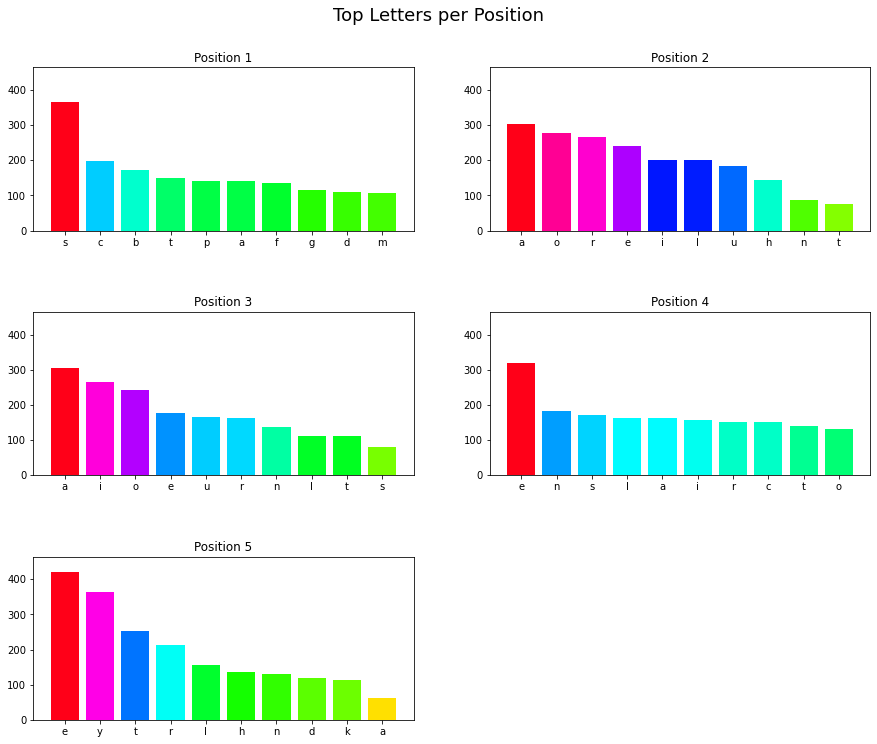

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Top Letters per Position", fontsize=18, y=0.95)

# set the number of bars to plot
top_n = 10

# set up colors for bars
# col_map = plt.get_cmap('Pastel1')
col_map = plt.get_cmap('YlOrRd')

# find the overall max value for consistent scaling
    # we need to ignore the last column since it includes the total score per word
y_max = df_cts.iloc[:,:-1].to_numpy().max()

# loop through the letter positions and keep track of index
for n, col in enumerate(colnames_all):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot letter frequency on the new subplot axis
    df_toplot = df_cts[col].sort_values(ascending=False).head(top_n)
    x = list(df_toplot.index.values)
    y = df_toplot
#     y_max = df_toplot.to_numpy().max()
    col_map = cm.hsv(y / float(max(y)))

#     ax.bar(x, y, color=col_map.colors)
    ax.bar(x, y, color=col_map)
#     ax.bar(x, y, cmap='YlOrRd')
    
    # chart formatting
    ax.set_title("Position "+str(n+1))
    ax.set_xlabel("")
    plt.ylim(0,y_max*1.1)

## Find best starting word
"Best" meaning the word composed of the highest-frequency letters.

Assign a score based on relative positional value?  
Simply use the frequency/count as this score?

For each word in the master list  
- Score each letter based on its frequency  
--- Could replace each letter with its frequency/score
- Sum scores to new column

In [11]:
# map score (per letter•position) back to word
df_freq = df_all.replace(df_cts)

In [12]:
# cacluate total score per word
df_freq = df_freq.drop(['score'], axis=1, errors='ignore')
col_to_sum = ['l1', 'l2', 'l3', 'l4', 'l5']
df_freq['score'] = df_freq[col_to_sum].sum(axis = 1).astype(int)
df_freq.head()

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni,score
0,aahed,False,140,304,9,318,118,4,False,889
1,aalii,False,140,304,112,158,11,3,False,725
2,aargh,False,140,304,163,76,137,4,False,820
3,aarti,False,140,304,163,139,11,4,False,757
4,abaca,False,140,16,306,150,63,3,False,675


In [13]:
# sort words by score
df_freq.sort_values('score',ascending=False).head(20)

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni,score
7919,saree,False,365,304,163,318,422,4,False,1572
8591,sooey,False,365,279,243,318,364,4,False,1569
8613,soree,False,365,279,163,318,422,4,False,1547
7858,saine,False,365,304,266,182,422,5,True,1539
8537,soare,False,365,279,306,150,422,5,True,1522
7851,saice,False,365,304,266,150,422,5,True,1507
8046,sease,False,365,241,306,171,422,3,False,1505
8044,seare,False,365,241,306,150,422,4,False,1484
8076,seine,False,365,241,266,182,422,4,False,1476
8409,slane,False,365,200,306,182,422,5,True,1475


## Plot the scores

In [14]:
import seaborn as sns
palette = sns.color_palette("Pastel1", 5).as_hex()
palette

['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']

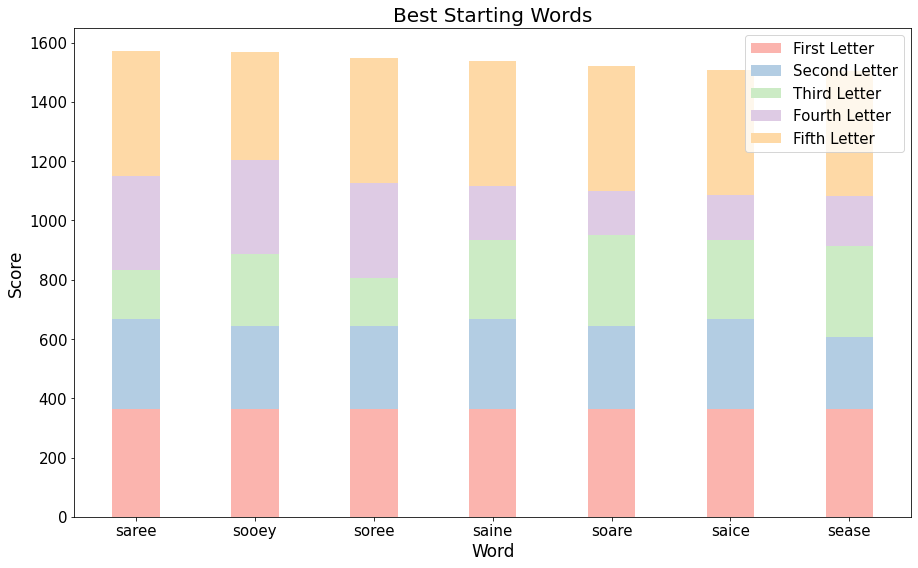

In [15]:
# plot top words and their contributions
# the plotting can probably be done more elegantly via a 'for' loop

# number of words to plot
top_n_words = 7

# Visualizing the data with stacked bar chart
plt.figure(figsize=[15, 9])

# downselect data to plot
df_freq_toplot = df_freq.sort_values('score',ascending=False).head(top_n_words)

# Set the width of the bars
wd = 0.4
x_pos = np.arange(len(df_freq_toplot))

# Plotting the multiple bar graphs on top on other
plt.bar(x_pos, df_freq_toplot.l1, color=palette[0], width=wd, label='First Letter')
plt.bar(x_pos, df_freq_toplot.l2, color=palette[1], width=wd, label='Second Letter', 
       bottom=df_freq_toplot.l1)
plt.bar(x_pos, df_freq_toplot.l3, color=palette[2], width=wd, label='Third Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2)
plt.bar(x_pos, df_freq_toplot.l4, color=palette[3], width=wd, label='Fourth Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3)
plt.bar(x_pos, df_freq_toplot.l5, color=palette[4], width=wd, label='Fifth Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3+df_freq_toplot.l4)

# Add xticks
plt.xticks(x_pos, df_freq_toplot.full_word.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Best Starting Words', fontsize=20)
plt.xlabel('Word', fontsize=17)
plt.ylabel('Score', fontsize=17)

plt.legend(loc='upper right', fontsize=15)
plt.show()

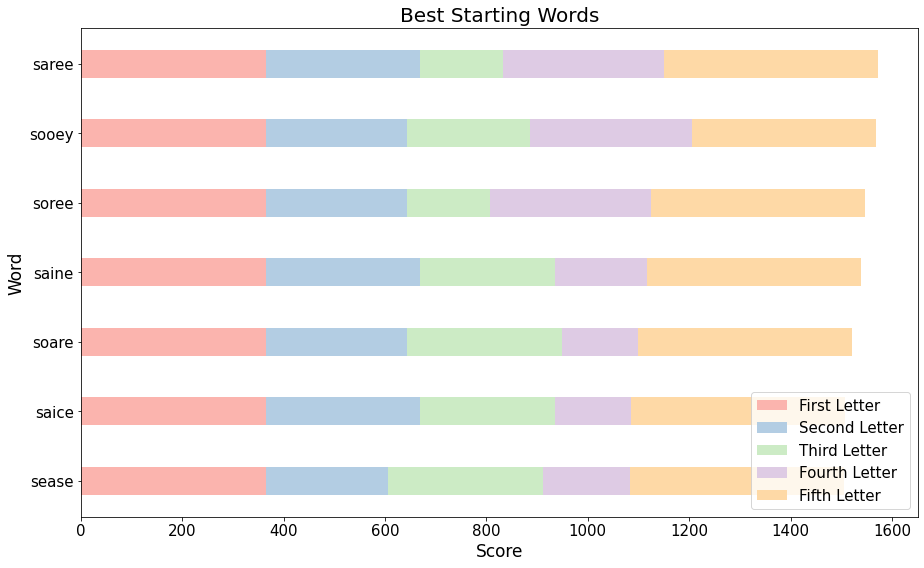

In [16]:
# ALT VERSION: horizontal stacked bar
# plot top words and their contributions
# the plotting can probably be done more elegantly via a 'for' loop

import numpy as np

# number of words to plot
top_n_words = 7

# Visualizing the data with stacked bar chart
plt.figure(figsize=[15, 9])

# downselect data to plot
df_freq_toplot = df_freq.sort_values('score',ascending=False).head(top_n_words).sort_values('score',ascending=True)

# Set the width of the bars
wd = 0.4
x_pos = np.arange(len(df_freq_toplot))

# Plotting the multiple bar graphs on top on other
plt.barh(x_pos, df_freq_toplot.l1, color=palette[0], height=wd, label='First Letter')
plt.barh(x_pos, df_freq_toplot.l2, color=palette[1], height=wd, label='Second Letter', 
       left=df_freq_toplot.l1)
plt.barh(x_pos, df_freq_toplot.l3, color=palette[2], height=wd, label='Third Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2)
plt.barh(x_pos, df_freq_toplot.l4, color=palette[3], height=wd, label='Fourth Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3)
plt.barh(x_pos, df_freq_toplot.l5, color=palette[4], height=wd, label='Fifth Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3+df_freq_toplot.l4)

# Add xticks
plt.yticks(x_pos, df_freq_toplot.full_word.values, fontsize=15)
plt.xticks(fontsize=15)
plt.title('Best Starting Words', fontsize=20)
plt.ylabel('Word', fontsize=17)
plt.xlabel('Score', fontsize=17)

plt.legend(loc='lower right', fontsize=15)
plt.show()

## --- THOROUGHLY CHECK THESE LOOKUPS ---

In [17]:
df_all.head()

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni
0,aahed,False,a,a,h,e,d,4,False
1,aalii,False,a,a,l,i,i,3,False
2,aargh,False,a,a,r,g,h,4,False
3,aarti,False,a,a,r,t,i,4,False
4,abaca,False,a,b,a,c,a,3,False


In [18]:
df_cts.head()

,l1,l2,l3,l4,l5,lxsum
letter,,,,,,
a,140,304,306,162,63,975
b,173,16,56,24,11,280
c,198,40,56,150,31,475
d,111,20,75,69,118,393
e,72,241,177,318,422,1230


In [19]:
df_freq.head()

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni,score
0,aahed,False,140,304,9,318,118,4,False,889
1,aalii,False,140,304,112,158,11,3,False,725
2,aargh,False,140,304,163,76,137,4,False,820
3,aarti,False,140,304,163,139,11,4,False,757
4,abaca,False,140,16,306,150,63,3,False,675


In [20]:
# Plot (stacked?) bar for top solutions


## Find the score of any specified 5-letter combination

In [27]:
# create a function that the user can call 
def score_word():
    word_to_score = input("What word would you like to score? ") # prompt for user input of a custom word
    if len(word_to_score) != 5: # make sure the user's word is the right length
        print('ERROR: Word must be exactly five letters long')
        return
    word_to_score = word_to_score.lower()

    # convert this single word to a dataframe so it works with the code we've already created
    df_temp = pd.DataFrame(word_to_score.split(), columns=['full_word'])

    # break up into individual letters
    df_temp,_ = extract_letters(df_temp)

    # map score (per letter•position) back to word
    df_temp = df_temp.replace(df_cts)
    df_temp['score'] = df_temp.sum(axis = 1)
    df_temp

    print('\"{}\" has a score of {}'.format(
        df_temp['full_word'][0],df_temp['score'][0]))
    print("This value is {}% of the max score ({})".format(
        round((df_temp['score'][0] / df_freq['score'].max())*100,1), df_freq['score'].max()))

    # plot
    # number of words to plot
    top_n_words = 1

    # Visualizing the data with stacked bar chart
    plt.figure(figsize=[8, 5])

    # downselect data to plot
    df_freq_toplot = df_freq.sort_values('score',ascending=False).head(top_n_words
                                              ).sort_values('score',ascending=True)
    # add user-specified word + score
    df_freq_toplot = df_freq_toplot.append(df_temp)

    # Set the width of the bars
    wd = 0.4
    x_pos = np.arange(len(df_freq_toplot))

    # Plotting the multiple bar graphs on top on other
    plt.barh(x_pos, df_freq_toplot.l1, color=palette[0], height=wd, label='First Letter')
    plt.barh(x_pos, df_freq_toplot.l2, color=palette[1], height=wd, label='Second Letter', 
           left=df_freq_toplot.l1)
    plt.barh(x_pos, df_freq_toplot.l3, color=palette[2], height=wd, label='Third Letter', 
           left=df_freq_toplot.l1+df_freq_toplot.l2)
    plt.barh(x_pos, df_freq_toplot.l4, color=palette[3], height=wd, label='Fourth Letter', 
           left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3)
    plt.barh(x_pos, df_freq_toplot.l5, color=palette[4], height=wd, label='Fifth Letter', 
           left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3+df_freq_toplot.l4)

    # Add xticks
    plt.yticks(x_pos, df_freq_toplot.full_word.values, fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Your Word vs. Best Starting Word', fontsize=20)
    plt.ylabel('Word', fontsize=17)
    plt.xlabel('Score', fontsize=17)

    plt.legend(loc='center right', fontsize=12)
    plt.show()

What word would you like to score? goofy
"goofy" has a score of 1036
This value is 65.9% of the max score (1572)


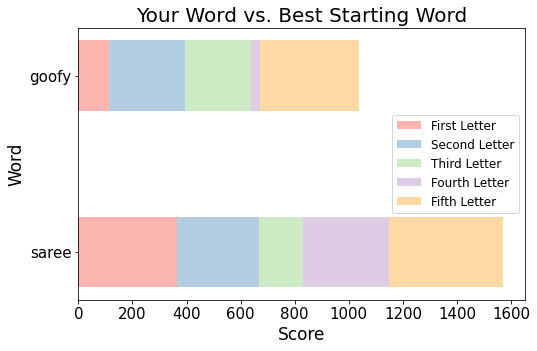

In [28]:
score_word()

## Find the best word if you're okay with a yellow
https://wordfinder.yourdictionary.com/blog/the-worst-wordle-words-that-only-hinder-your-game/  

## BONUS: Find best option given a known letter/position

### References
https://stackoverflow.com/questions/51896168/create-new-data-frame-with-the-name-from-loop-number

https://towardsdatascience.com/easy-grouped-bar-charts-in-python-b6161cdd563d  
https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/  
https://pythonguides.com/matplotlib-plot-bar-chart/  
https://engineeringfordatascience.com/posts/matplotlib_subplots/

https://matplotlib.org/stable/gallery/color/colormap_reference.html  
https://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value  
https://holypython.com/python-visualization-tutorial/colors-with-python/

https://stackoverflow.com/questions/53118854/replace-values-in-dataframe-using-a-lookup-dataframe

### Scrapyard

In [24]:
# compare to the closest starting word to the word I personally used ("strep")
df_freq.loc[df_freq['full_word'] == 'strap']

,full_word,is_sol,l1,l2,l3,l4,l5,n_uni,all_uni,score
1942,strap,True,365,77,163,162,56,5,True,823


In [ ]:
# df_c1 = df.value_counts('l1').rename_axis('letter').reset_index(name='ct_l1')
# df_c1

In [ ]:
# # df.value_counts('l1').to_frame()

# value_counts = df['l1'].value_counts()

# # converting to df and assigning new names to the columns
# df_value_counts = pd.DataFrame(value_counts)
# # df_value_counts = df_value_counts.reset_index()
# df_value_counts.columns = ['ct_l1'] # change column names
# df_value_counts

In [ ]:

# # converting to df and assigning new names to the columns
# df_value_counts = pd.DataFrame(df['l1'].value_counts())
# df_value_counts.columns = ['ct_l1'] # change column names
# df_value_counts

In [ ]:
# df_ct_all = pd.merge(df_c1, df_c2, on = 'letter', how = 'outer')

# # need to clean up NaNs (replace with 0)
# # convert all to integer

# df_ct_all

In [ ]:
import matplotlib.pyplot as plt

df_toplot = df_cts['l1'].sort_values(ascending=False).head()

# my_cmap = plt.get_cmap("viridis")
# col_map = plt.get_cmap('tab20c')
col_map = plt.get_cmap('Pastel1')
my_colors = ['r', 'y', 'g', 'b', 'c']

# x = df_toplot['letter']
x = list(df_toplot.index.values)
y = df_toplot
plt.bar(x, y, color=col_map.colors)

plt.xlabel('Letter')
plt.ylabel('Count')
plt.title('Top Letters for Position 1')

plt.show()

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Top Letters per Position", fontsize=18, y=0.95)

# my_cmap = plt.get_cmap("viridis")
# col_map = plt.get_cmap('tab20c')
col_map = plt.get_cmap('Pastel1')
my_colors = ['r', 'y', 'g', 'b', 'c']

# loop through the length of tickers and keep track of index
for n, col in enumerate(colnames_all):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis
#     df[df["colname"] == col].plot(ax=ax)
    df_toplot = df_cts[col].sort_values(ascending=False).head()
    x = list(df_toplot.index.values)
    y = df_toplot
    ax.bar(x, y, color=col_map.colors)


    # chart formatting
#     ax.set_title(col.upper())
    ax.set_title("Position "+str(n+1))
#     ax.get_legend().remove()
    ax.set_xlabel("")